In [0]:
!pip install google-cloud-storage google-cloud-bigquery xgboost db-dtypes

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

### Variables details :

1. **`Voltage_measured`**:
   - The measured voltage of the heater at different instances (possibly during cycles or time points). For example, at time point 0, the voltage is approximately 3.97 V.

2. **`Current_measured`**:
   - The measured current flowing through the heater at different instances. Negative values might indicate the direction of the current.

3. **`Temperature_measured`**:
   - The measured temperature of the heater at different instances.

4. **`Current_charge`**:
   - The current used for charging the heater.
   
5. **`Voltage_charge`**:
   - The voltage used for charging the heater.

6. **`Time`**:
   - The time at which the measurements or events are recorded.

7. **`Capacity`**:
   - The capacity of the heater.

8. **`id_cycle`**:
   - A unique identifier for a cycle or heating event.
   
9. **`type`**:
   - The type of heater or a categorical variable indicating the type of measurement or cycle. In this case, all instances are labeled as 'heater'.

10. **`ambient_temperature`**:
    - The ambient (surrounding) temperature during the measurement or cycle.

11. **`time`**:
    - Another time-related variable, possibly the year when the measurements were taken.

12. **`PhID`**:
    - A unique identifier for the physical device or heater.


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from heater_health_data import load_csv_data_from_bucket,load_csv_data_from_bigquery

No such comm: LSP_COMM_ID
No such comm: LSP_COMM_ID
No such comm: LSP_COMM_ID
No such comm: LSP_COMM_ID


In [0]:
### import data from local folder

data = 'heater_train_test_data.csv'

df = pd.read_csv(data)

### import data from gcp bucket folder
# df = load_csv_data_from_bucket(data)

### import data from bigquery
# df = load_csv_data_from_bigquery(data)

df

Voltage_measured  Current_measured  ...  time_year   PhID
0               3.974871         -2.012528  ...       2008  B0005
1               3.951717         -2.013979  ...       2008  B0005
2               3.934352         -2.011144  ...       2008  B0005
3               3.920058         -2.013007  ...       2008  B0005
4               3.907904         -2.014400  ...       2008  B0005
...                  ...               ...  ...        ...    ...
169761          2.835283         -2.011160  ...       2008  B0018
169762          2.774711         -2.011370  ...       2008  B0018
169763          2.690974         -2.010542  ...       2008  B0018
169764          2.566085         -2.011117  ...       2008  B0018
169765          2.365585         -2.011110  ...       2008  B0018

[169766 rows x 12 columns]

In [0]:
df.columns

Index(['Voltage_measured', 'Current_measured', 'Temperature_measured',
       'Current_charge', 'Voltage_charge', 'Time', 'Capacity', 'id_cycle',
       'type', 'ambient_temperature', 'time_year', 'PhID'],
      dtype='object')

In [0]:
df.shape

(169766, 12)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169766 entries, 0 to 169765
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Voltage_measured      169766 non-null  float64
 1   Current_measured      169766 non-null  float64
 2   Temperature_measured  169766 non-null  float64
 3   Current_charge        169766 non-null  float64
 4   Voltage_charge        169766 non-null  float64
 5   Time                  169766 non-null  float64
 6   Capacity              169766 non-null  float64
 7   id_cycle              169766 non-null  int64  
 8   type                  169766 non-null  object 
 9   ambient_temperature   169766 non-null  int64  
 10  time_year             169766 non-null  int64  
 11  PhID                  169766 non-null  object 
dtypes: float64(7), int64(3), object(2)
memory usage: 15.5+ MB


In [0]:
df['PhID'].value_counts()

B0007    48299
B0005    45122
B0006    44354
B0018    31991
Name: PhID, dtype: int64

In [0]:
# Check null values
df.isnull().sum().sort_values() 

Voltage_measured        0
Current_measured        0
Temperature_measured    0
Current_charge          0
Voltage_charge          0
Time                    0
Capacity                0
id_cycle                0
type                    0
ambient_temperature     0
time_year               0
PhID                    0
dtype: int64

- No null values present in any variable

In [0]:
# Check duplicates
duplicates = df[df.duplicated()]
duplicates.shape

(0, 12)

- No duplicates present.

In [0]:
# categorical variables
categorical_var = []
for i in df.columns :
    if df[i].dtypes=='object':
        categorical_var.append(i)
categorical_var

['type', 'PhID']

In [0]:
# categorical variables
numerical_var = []
for i in df.columns :
    if df[i].dtypes=='int' or df[i].dtypes=='float':
        numerical_var.append(i)
numerical_var

['Voltage_measured',
 'Current_measured',
 'Temperature_measured',
 'Current_charge',
 'Voltage_charge',
 'Time',
 'Capacity',
 'id_cycle',
 'ambient_temperature',
 'time_year']

In [0]:
# statistical description of each variable
df.describe()

Voltage_measured  Current_measured  ...  ambient_temperature  time_year
count     169766.000000     169766.000000  ...             169766.0   169766.0
mean           3.503756         -2.004652  ...                 24.0     2008.0
std            0.245871          0.009801  ...                  0.0        0.0
min            1.737030         -2.029098  ...                 24.0     2008.0
25%            3.389014         -2.011621  ...                 24.0     2008.0
50%            3.507333         -2.009471  ...                 24.0     2008.0
75%            3.665754         -1.991235  ...                 24.0     2008.0
max            4.035025         -1.974808  ...                 24.0     2008.0

[8 rows x 10 columns]

In [0]:
df[categorical_var].describe()

type    PhID
count   169766  169766
unique       1       4
top     heater   B0007
freq    169766   48299

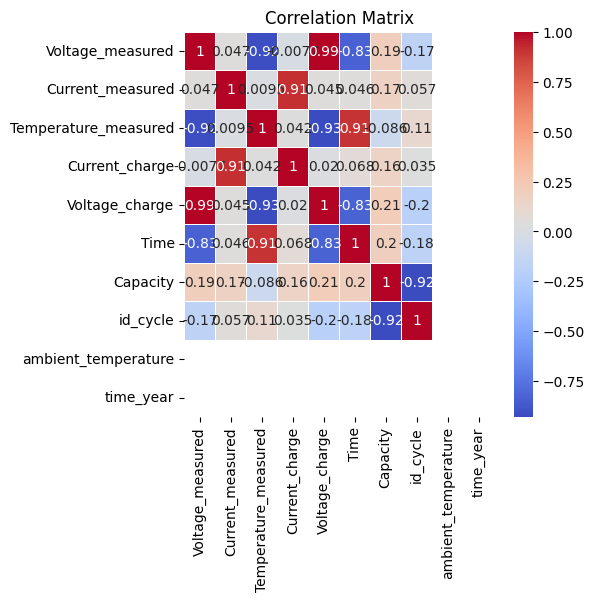

In [0]:
# Pearson correlation matrix
corr_matrix = df[numerical_var].corr('pearson')
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

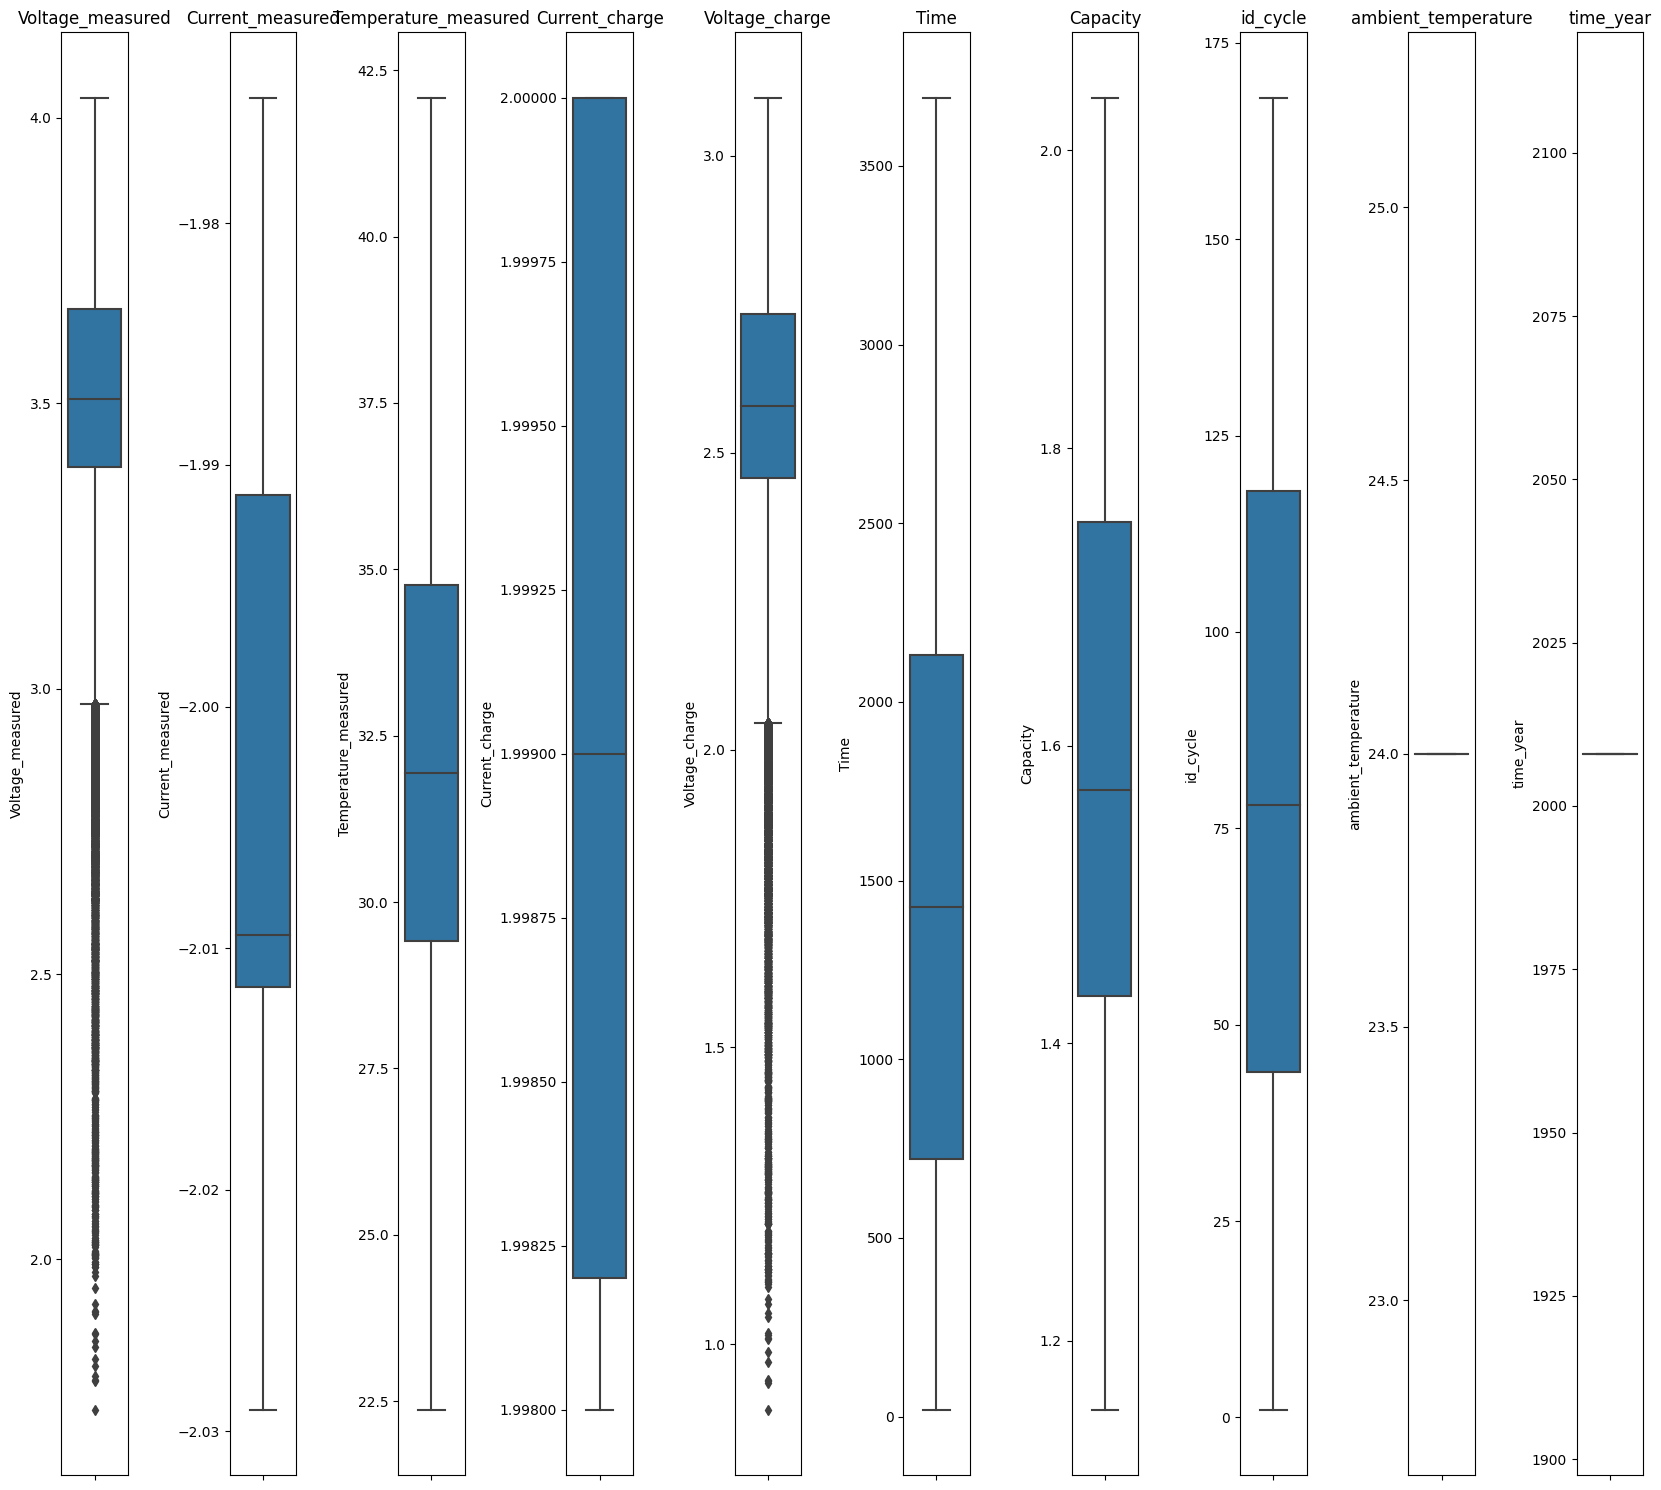

In [0]:
# create a boxplot
plt.figure(figsize=(20, 15))
for i, column in enumerate(numerical_var):
    plt.subplot(1, len(df.columns), i+1)
    sns.boxplot(y=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

## Scatter plot 
### Select variable from features list for visualization

In [0]:
# Scatter plot function execution
from  heater_health_data import scatterplot
data='heater_train_test_data.csv'
device_id=['B0005','B0006','B0007','B0018']         # B0005,B0006,B0007,B0018
x_axis='Time'
y_axis='Voltage_measured' # ['Voltage_measured','Current_measured','Temperature_measured','Current_charge','Voltage_charge','Capacity']
legend='id_cycle'
legend_value = None

scatterplot(data, device_id, x_axis, y_axis, legend, legend_value)

#### From above scatter plots :
- `Voltage_measured and Voltage_charge decrease with time and its time will decrease with id_cycle, Temperature_measured increase with time and id_cycle, capacity of the heater decreases with id_cycle.`